<a href="https://colab.research.google.com/github/daoudecho/Data-Visualization-Python/blob/master/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df=pd.read_csv("/content/aadr.us.txt", sep=",")
print(df.head())
print(df.info())

         Date    Open    High     Low   Close  Volume  OpenInt
0  2010-07-21  24.333  24.333  23.946  23.946   43321        0
1  2010-07-22  24.644  24.644  24.362  24.487   18031        0
2  2010-07-23  24.759  24.759  24.314  24.507    8897        0
3  2010-07-26  24.624  24.624  24.449  24.595   19443        0
4  2010-07-27  24.477  24.517  24.431  24.517    8456        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 7 columns):
Date       1565 non-null object
Open       1565 non-null float64
High       1565 non-null float64
Low        1565 non-null float64
Close      1565 non-null float64
Volume     1565 non-null int64
OpenInt    1565 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 85.7+ KB
None


In [81]:
features_considered = ['Open', 'High', 'Close']
features = df[features_considered]
features.index = df['Date']
features.head()

,Open,High,Close
Date,,,
2010-07-21,24.333,24.333,23.946
2010-07-22,24.644,24.644,24.487
2010-07-23,24.759,24.759,24.507
2010-07-26,24.624,24.624,24.595
2010-07-27,24.477,24.517,24.517


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3b1672f60>,
      dtype=object)

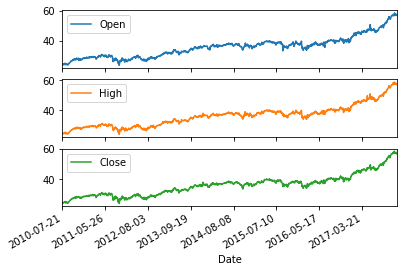

In [82]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

In [132]:
print(dataset)

[[-1.67946379 -1.68622812 -1.73719192]
 [-1.63475113 -1.64180152 -1.65914354]
 [-1.6182175  -1.62537368 -1.65625821]
 ...
 [ 3.06166018  3.05884726  3.10209602]
 [ 3.05015853  3.013135    3.02080164]
 [ 3.01134046  2.97456528  2.94484513]]


In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 1000
past_history = 520
future_target = 10
STEP = 3

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [143]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (174, 3)


In [128]:
!pip install tensorflow==2.0.0b1

In [129]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
BATCH_SIZE = 250
BUFFER_SIZE = 500
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [145]:
print(val_data_single)


<RepeatDataset shapes: ((None, 174, 3), (None,)), types: (tf.float64, tf.float64)>


In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [147]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(35, 1)


In [148]:
EVALUATION_INTERVAL = 50
EPOCHS = 10
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=30)

Epoch 1/10
50/50 [==============================] - 11s 221ms/step - loss: 0.1041 - val_loss: 2.0548
Epoch 2/10
50/50 [==============================] - 9s 178ms/step - loss: 0.0980 - val_loss: 1.8147
Epoch 3/10
50/50 [==============================] - 9s 177ms/step - loss: 0.0956 - val_loss: 1.7642
Epoch 4/10
50/50 [==============================] - 9s 177ms/step - loss: 0.0919 - val_loss: 1.6458
Epoch 5/10
50/50 [==============================] - 9s 182ms/step - loss: 0.0851 - val_loss: 1.5639
Epoch 6/10
50/50 [==============================] - 9s 181ms/step - loss: 0.0787 - val_loss: 1.8081
Epoch 7/10
50/50 [==============================] - 9s 180ms/step - loss: 0.0750 - val_loss: 1.8985
Epoch 8/10
50/50 [==============================] - 9s 178ms/step - loss: 0.0713 - val_loss: 1.9966
Epoch 9/10
50/50 [==============================] - 9s 181ms/step - loss: 0.0683 - val_loss: 2.1347
Epoch 10/10
50/50 [==============================] - 9s 180ms/step - loss: 0.0672 - val_loss: 2.085

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

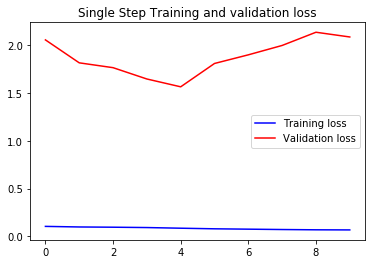

In [150]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

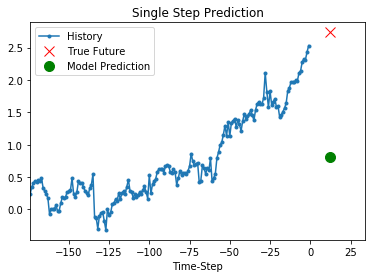

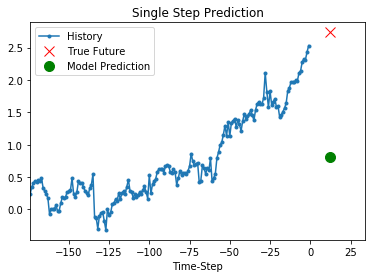

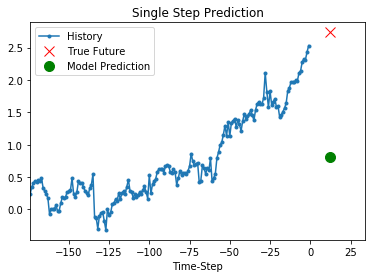

In [153]:

for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 10
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [155]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(x_val_multi.shape))

Single window of past history : (174, 3)

 Target temperature to predict : (10,)

 Target temperature to predict : (35, 174, 3)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [157]:
print(val_data_multi)

<RepeatDataset shapes: ((None, 174, 3), (None, 10)), types: (tf.float64, tf.float64)>


In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

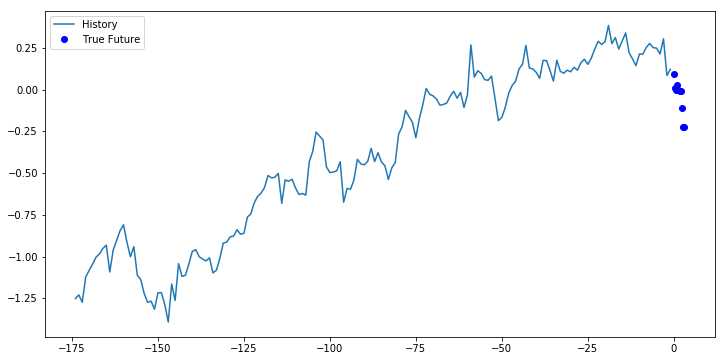

In [159]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(10))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [161]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(35, 10)


In [162]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=30)

Epoch 1/10
50/50 [==============================] - 21s 424ms/step - loss: 0.1550 - val_loss: 1.9876
Epoch 2/10
50/50 [==============================] - 18s 351ms/step - loss: 0.1056 - val_loss: 1.6831
Epoch 3/10
50/50 [==============================] - 16s 327ms/step - loss: 0.1916 - val_loss: 1.4897
Epoch 4/10
50/50 [==============================] - 16s 324ms/step - loss: 3.2980 - val_loss: 1.5479
Epoch 5/10
50/50 [==============================] - 16s 321ms/step - loss: 0.0938 - val_loss: 1.5586
Epoch 6/10
50/50 [==============================] - 16s 323ms/step - loss: 0.0949 - val_loss: 1.5597
Epoch 7/10
50/50 [==============================] - 16s 323ms/step - loss: 0.0912 - val_loss: 1.5261
Epoch 8/10
50/50 [==============================] - 16s 321ms/step - loss: 0.0885 - val_loss: 1.4423
Epoch 9/10
50/50 [==============================] - 16s 325ms/step - loss: 0.0850 - val_loss: 1.4004
Epoch 10/10
50/50 [==============================] - 16s 322ms/step - loss: 0.0822 - val_lo

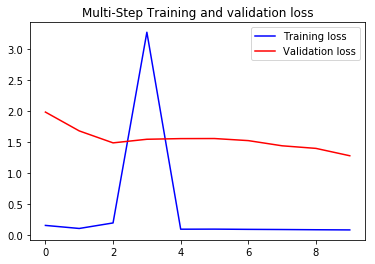

In [163]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

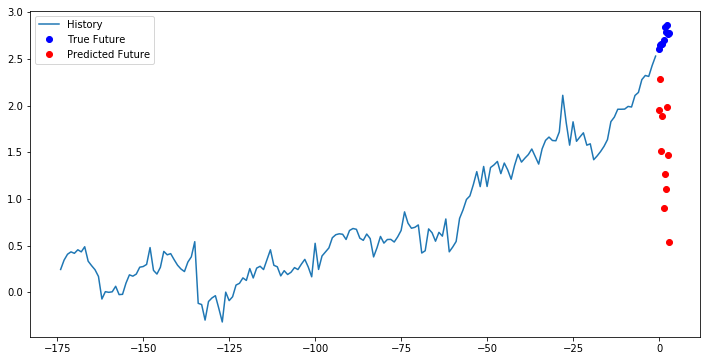

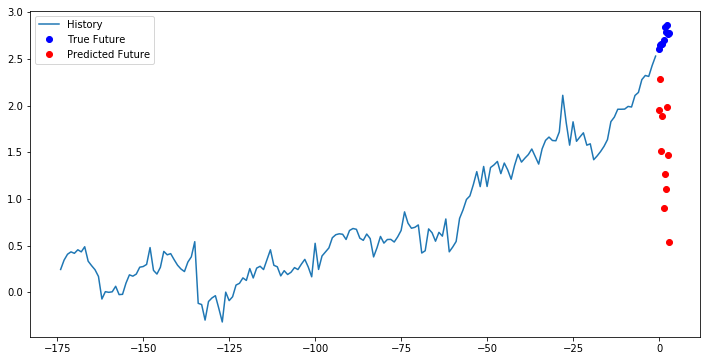

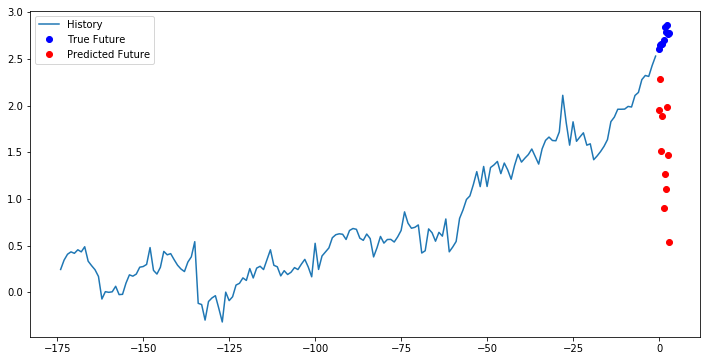

In [164]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])